# Machine Learning, Python y el Titanic

#### Izaskun Mendia (@izaskun.mendia) - Basado en el capítulo 2 del libro "Learning scikit-learn: Machine Learning in Python"

_¿Es posible crear hipótesis sobre quiénes se salvaron en el Titanic? En este pequeño ejercicio, intentaremos generarlas a partir de la información que tenemos de los pasajeros, sabiendo si se salvaron o no. Para esto, el modelo predictivo a utilizar serán Árboles de Decisión. El conjunto de datos (dataset) a utilizar puede bajarse aquí (http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt)_

Importamos las bibliotecas que vamos a utilizar. Las principales son numpy (la biblioteca principal para computación científica con Python), y, por supuesto scikit-learn (que nos permitirá entrenar y aplicar el modelo elegido).

In [1]:
%matplotlib inline
import IPython
import sklearn as sk
import numpy as np
import seaborn as sns
import pandas as pd

print 'IPython version:', IPython.__version__
print 'numpy version:', np.__version__
print 'scikit-learn version:', sk.__version__
print 'seaborn version:', sns.__version__
print 'pandas version:', pd.__version__

IPython version: 5.1.0
numpy version: 1.11.1
scikit-learn version: 0.18.1
seaborn version: 0.7.0
pandas version: 0.19.0


# Preprocesamiento e Ingeniería de Atributos

Utilizamos la libreria pandas. A mi modo de ver, una librería esencial.
Pandas es una librería open source que aporta a Python unas estructuras de datos fáciles de usar y de alta performance, junto con un gran número de funciones esenciales para el análisis de datos. Con la ayuda de Pandas podemos trabajar con datos estructurados de una forma más rápida y expresiva.
Le indicamos que no nos muestre los warnings...

In [2]:
pd.options.mode.chained_assignment = None  # Para que pandas no saque warnings relativos a versiones y demas historias

Vamos a leer el archivo que tenemos...

La lista de atributos es: Ordinal, Class, Survived (0=no, 1=yes), Name, Age, Port of Embarkation, Home/Destination, Room, Ticket, Boat, and Sex. 
Empecemos por cargar nuestro archivo a una estructura DataFrame de Pandas(herramienta para manejar estos atributos):

In [3]:
titanic_dataset = pd.read_csv('./data/titanic.txt', sep=',')

# La primera fila tiene los nombres de los atributos
print titanic_dataset.columns.values

['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']


Veamos cómo quedan las tuplas...

In [4]:
titanic_dataset.iloc[8]

row.names                                               9
pclass                                                1st
survived                                                1
name         Appleton, Mrs Edward Dale (Charlotte Lamson)
age                                                    58
embarked                                      Southampton
home.dest                             Bayside, Queens, NY
room                                                C-101
ticket                                                NaN
boat                                                    2
sex                                                female
Name: 8, dtype: object

La primera tupla corresponde a Elisabeth Walton, de 29 años, que embarcó en Southampton, iba a St. Louis,estaba en el cuarto B-5, y tenía el ticket 24160 L221, en primera clase. Elisabeth sobrevivió.Estos datos los tenemos para todos los pasajeros. Aquí es donde tenemos que elegir las features que vamos a usar para aprender. En este caso, elegimos la clase, la edad, y el sexo. El destino no parece influenciar mucho, dónde embarcó tampoco... de acuerdo a nuestro conocimiento... aunque nada nos impide agregarlo luego como feature. El nombre no puede ir, ya que es imposible que sirva para generalizar. Por supuesto, no podemos usar para predecir la clase que estamos tratando de adivinar, así que la columna "survived" también desaparece.

Veamos la relación de personas que se salvarón y las que no pudo ser:

In [5]:
# En la columna 3 tenemos la clase que queremos predecir (es decir, si sobrevivió o no)
# Vale 1 si sobrevivió, 0 si no. Miramos el porcentaje de cada grupo.
titanic_dataset.survived.value_counts(normalize=True)

0    0.658035
1    0.341965
Name: survived, dtype: float64

In [6]:
# Elegimos las columnas que tiene la clase, la edad, y el sexo
titanic_X = titanic_dataset[['pclass','age','sex']]
titanic_y = titanic_dataset[['survived']]

Tenemos algunos problemas con la edad: en algunos casos no tiene valores:

In [7]:
print titanic_X.iloc[[14]]

   pclass  age   sex
14    1st  NaN  male


Tenemos que hacer algo: elegimos poner el valor medio...

In [8]:
# Calculo la edad promedio
edades = titanic_X.age
edad_promedio = edades.mean()
print edad_promedio

31.1941810427


Actualizo las valores nulos.

In [9]:
# Actualizo
titanic_X.fillna(edad_promedio, inplace=True)

print titanic_X.iloc[[14]]

   pclass        age   sex
14    1st  31.194181  male


Bien. Veamos ahora la clase y el sexo: el clasificador que vamos a usar espera atributos que son números reales y en este caso, los tenemos como categorías. Empecemos por sexo: solamente hay dos categorías, por lo que podemos decir (por ejemplo) que femenino es 0 y masculino es 1. scikit-learn nos provee de una clase LabelEncoder que hace esto...:

In [10]:
titanic_X.values

array([['1st', 29.0, 'female'],
       ['1st', 2.0, 'female'],
       ['1st', 30.0, 'male'],
       ..., 
       ['3rd', 31.19418104265403, 'male'],
       ['3rd', 31.19418104265403, 'female'],
       ['3rd', 31.19418104265403, 'male']], dtype=object)

In [11]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
# Le paso los valores que tengo y el asigna un entero a cada clase posible
label_encoder = enc.fit(titanic_X.sex.values)
print "Categorical classes:", label_encoder.classes_

# Veamos como las transforma...
integer_classes = label_encoder.transform(label_encoder.classes_)
print "Integer classes:", zip(label_encoder.classes_,integer_classes)

sex_encoder = label_encoder.transform(titanic_X.sex.values)
titanic_X['sex'] = sex_encoder
print titanic_X.head()

Categorical classes: ['female' 'male']
Integer classes: [('female', 0), ('male', 1)]
  pclass      age  sex
0    1st  29.0000    0
1    1st   2.0000    0
2    1st  30.0000    1
3    1st  25.0000    0
4    1st   0.9167    1


Bien, nos resta la clase del pasajero. Tenemos primera, segunda y tercera. Para evitar un ordenamiento implícito (0<1<2), vamos a usar otra técnica, llamada "One Hot Encoding". Lo mejor es verlo con un ejemplo, pero la idea es convertir cada atributo en n, siendo n los valores posibles de ese atributo. Para este caso, generaremos los atributos: primera_clase, segunda_clase, y tercera_clase, valuados en 0/1.

In [12]:
from sklearn.preprocessing import OneHotEncoder

lencoder = LabelEncoder()
label_encoder = lencoder.fit(titanic_X['pclass'])
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3,1)
enc = OneHotEncoder()
one_hot_encoder=enc.fit(integer_classes)

# First, convert clases to 0-(N-1) integers using label_encoder
num_of_rows = titanic_X.shape[0]
pclass_encoder = label_encoder.transform(titanic_X['pclass']).reshape(num_of_rows, 1)

# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = one_hot_encoder.transform(pclass_encoder)

# Add the new features to titanix_X
titanic_X['primera_clase'] = new_features.toarray()[:,0].tolist()
titanic_X['segunda_clase'] = new_features.toarray()[:,1].tolist()
titanic_X['tercera_clase'] = new_features.toarray()[:,2].tolist()

# Eliminate converted columns
del titanic_X['pclass']

In [13]:
feature_names = titanic_X.columns.values

print 'Values:\n',titanic_X.loc[[14]]
print 'Objetivo:\n', titanic_y.loc[[14]]

Values:
          age  sex  primera_clase  segunda_clase  tercera_clase
14  31.194181    1            1.0            0.0            0.0
Objetivo:
    survived
14         0


Mostramos las 5 primeras filas...

In [14]:
print titanic_X.head()

       age  sex  primera_clase  segunda_clase  tercera_clase
0  29.0000    0            1.0            0.0            0.0
1   2.0000    0            1.0            0.0            0.0
2  30.0000    1            1.0            0.0            0.0
3  25.0000    0            1.0            0.0            0.0
4   0.9167    1            1.0            0.0            0.0


Vamos a analizar los datos ... sería interesante saber si analizar edad, la clase y el sexo nos aporta algo de información. Para ello utilizamos un diagrama de cajas.

Los diagramas de cajas son una presentación visual que describe varias características importantes al mismo tiempo, tales como la dispersión y simetría. Para su realización se representan los tres cuartiles y los valores mínimo y máximo de los datos, sobre un rectángulo, alineado horizontal o verticalmente. Estos gráficos nos proporcionan abundante información y son sumamente útiles para encontrar valores atípicos y comparar dos conjunto de datos.

Miramos si la edad de los que sobrevivian es una caracteristica relevante...

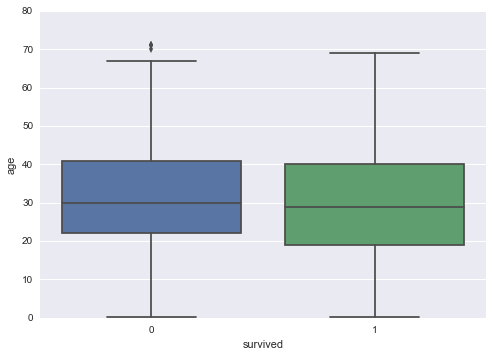

In [15]:
sns.boxplot(y=titanic_dataset['age'], x=titanic_dataset['survived'])

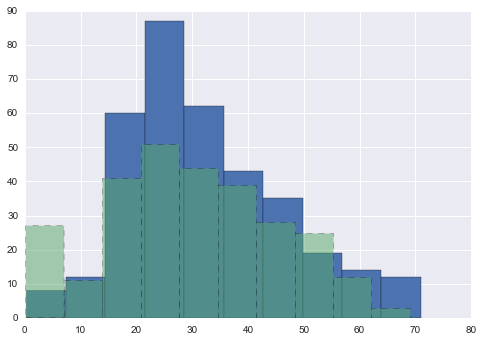

In [16]:
titanic_dataset['age'][(titanic_dataset['survived']==0)].hist()
titanic_dataset['age'][(titanic_dataset['survived']==1)].hist(ls='dashed', lw=0.5, alpha=0.5)

Ya tenemos el dataset, ahora comienza el proceso de aprendizaje. 
Vamos primero separar el dataset en dos: un conjunto de entrenamiento y otro de testeo. Trabajaremos siempre sobre el de entrenamiento, y dejamos el de testeo para evaluar nuestros resultados. Lo dividimos en 75/25:

In [17]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)

D:\Users\106298\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Arboles de decisión

Vamos a crear a partir de los datos de entrenamiento, un árbol de decision. Esto en scikit-learn es estándar... y fácil, una vez que tenemos los datos en el formato pedido: basta crear el clasificador y usarlo para generar el modelo:

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

A partir de los datos de entrenamiento, nuestro arbol de decisión muestra un conjunto de decisiones.Para clasificar una istania, en cada nodo debemos responder a una pregunta. Por ejemplo, en el nodo principal, la pregunta es : es sex>=0.5? (es decir, hablamos de una mujer?). Si la respuesta es sí, nos desviamos hacia la rama de la izquierda; en caso contrario, nos desviamos a la rama derecha. Y continuamos respondiendo preguntas (estaba ela en 3ª clase? estaba ella en 1ª clase? era menor de 13 años?) y asi hasta llegar a una hoja. Al llegar a una hoja, se le asigna una predicción. 
Dibujamos el arbol utilizando pyplot:

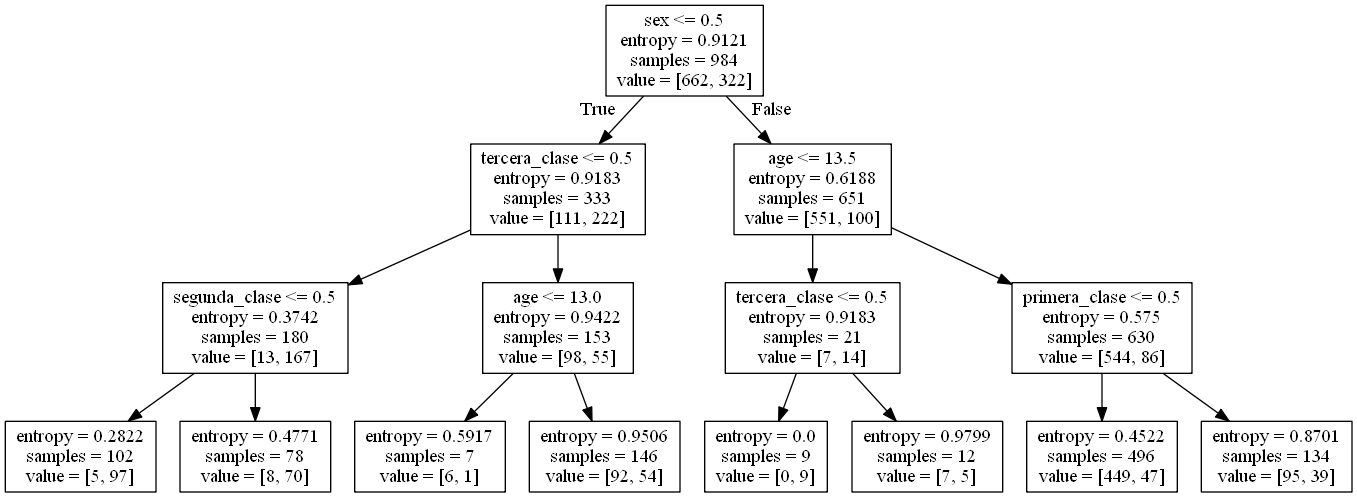

In [19]:
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image  

dot_data=StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

Veamos cómo funciona nuestro modelo.
¿Cúal es la probabilidad de sobrevivir en función del sexo y clase?

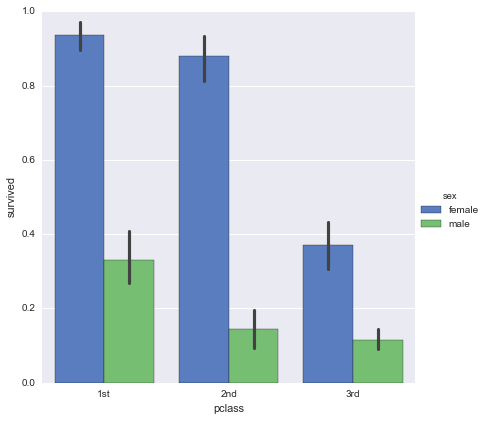

In [20]:
sns.factorplot("pclass", "survived", "sex", data=titanic_dataset, kind="bar", size=6, palette="muted", legend=True)

Supongamos que había un hombre de 20 años en tercera clase (a.k.a. Leonardo di Caprio)... ¿se hubiera salvado?

In [21]:
print clf.predict([[20.0,1.0,0.0,0.0,1.0]])

[0]


Upps, Nop. Podemos verificarlo siguiendo el árbol... 

Pero, ¿cómo sabemos cómo de bueno es nuestro clasificador? Empecemos por evaluarlo sobre los propios datos de entrenamiento, y viendo en cuántos casos acierta (esta medida se llama accuracy)... y algunas medidas más.

In [22]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
measure_performance(X_train,y_train,clf, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.838 

Classification report
             precision    recall  f1-score   support

          0       0.82      0.98      0.89       662
          1       0.93      0.55      0.69       322

avg / total       0.85      0.84      0.82       984


Confusion matrix
[[649  13]
 [146 176]] 



El problema así enfocado tiene su riesgo, y es que estamos evaluando sobre los mismos datos que utilizamos para crear el modelo! Esto siempre es una mala idea... para eso guardamos nuestro dataset de evaluación... evaluemos cómo se comporta nuestro modelo sobre este dataset: 

In [23]:
measure_performance(X_test,y_test, clf, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

          0       0.77      0.96      0.85       202
          1       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329


Confusion matrix
[[193   9]
 [ 59  68]] 

